In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time


In [182]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

df.head()

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
coords = []
for idx, row in df.iterrows():
    frame_num = int(row['frame_idx'])
    image_path = f"output/{frame_num}.png"
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))
    images.append(image)
    h = row['h']
    scale = 128/h

    df.at[idx, 'ellipse_x'] *= scale
    df.at[idx, 'ellipse_y'] *= scale
    df.at[idx, 'ellipse_h'] *= scale/2
    df.at[idx, 'ellipse_w'] *= scale/2
    df.at[idx, 'h'] *= scale
    df.at[idx, 'w'] *= scale
    coords.append((row['ellipse_x'] * scale, row['ellipse_y'] * scale, row['ellipse_w'] * scale/2, row['ellipse_h'] * scale/2))



image_numbers 1158


C:\Users\NateLy\AppData\Local\Temp\ipykernel_27220\2226100701.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'h'] *= scale
C:\Users\NateLy\AppData\Local\Temp\ipykernel_27220\2226100701.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'w'] *= scale


In [183]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, coords, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)
y_test  = np.array(y_test, dtype=np.float32)
def build_model():
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4)  # Output: x, y
    ])
    return model

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()




Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,572 (6.22 MB)

 Trainable params: 1,629,572 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
print("x shape", X_train.shape, "y shape", y_train.shape)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

start = time.time()

preds = model.predict(X_test[:100])
end = time.time()
print(f"Predictions per second: {100 / (end - start):.2f}")
# print("Predicted coords:", preds)
# print("Actual coords:", y_test[:100])

# find mean absolute error for the x and y coordinates



x shape (686, 128, 128) y shape (686, 4)
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.6938 - mae: 0.6419 - val_loss: 6.1819 - val_mae: 1.2319
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7262 - mae: 0.6632 - val_loss: 5.5961 - val_mae: 1.0881
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.8500 - mae: 0.7313 - val_loss: 5.3458 - val_mae: 1.0536
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.7744 - mae: 0.6948 - val_loss: 5.4983 - val_mae: 1.1048
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0309 - mae: 0.7574 - val_loss: 6.2919 - val_mae: 1.2933
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9662 - mae: 0.7719 - val_loss: 6.0158 - val_mae: 1.3775
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.5012 - mae: 0.9514 - val_loss: 5.4195 - val_mae: 1.0408
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0737 - mae: 0.7948 - val_loss: 5.2952 - val_mae: 1.0678
Epoch 9/10
43/43 ━━━━━━

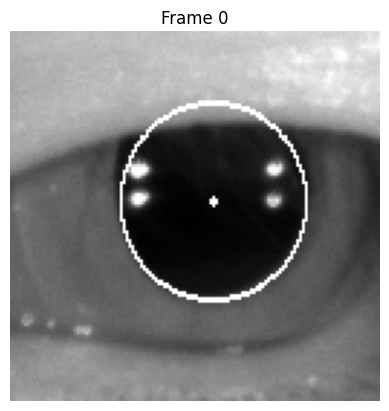

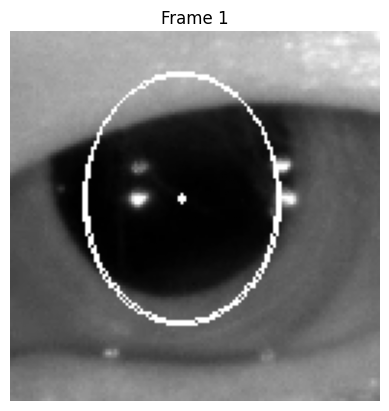

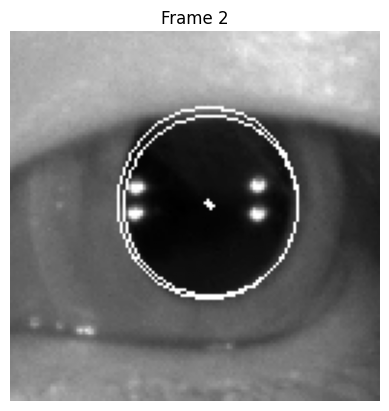

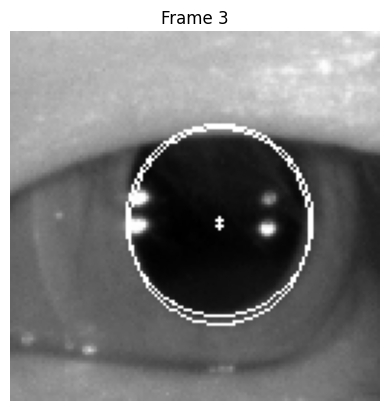

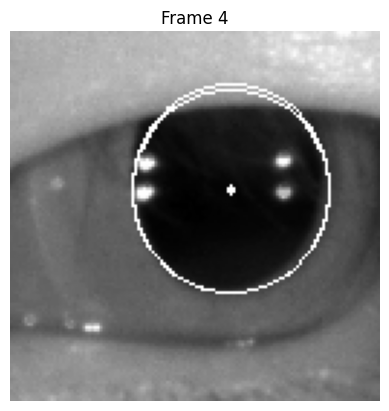

In [186]:
# plot images with elipses and centers of actual vs predicted
for i in range(5):
    image = X_test[i].reshape(128, 128)
    # convert to grayscale
    entry = y_test[i]
    pred = preds[i]

    ellipse_x = int(entry[0])
    ellipse_y = int(entry[1])
    ellipse_w = int(entry[2])
    ellipse_h = int(entry[3])

    pred_x = int(pred[0])
    pred_y = int(pred[1])
    pred_w = int(pred[2])
    pred_h = int(pred[3])
    actual_color = (255, 255, 0)
    pred_color = (255, 255, 255)

    plt.imshow(image, cmap='gray')
    plt.title(f"Frame {i}")
    cv2.ellipse(image, (ellipse_x, ellipse_y), (ellipse_w, ellipse_h), 0, 0, 360, actual_color, 1)
    cv2.circle(image, (ellipse_x, ellipse_y), 1, actual_color, -1)

    cv2.ellipse(image, (pred_x, pred_y), (pred_w, pred_h), 0, 0, 360, pred_color, 1)
    cv2.circle(image, (pred_x, pred_y), 1, pred_color, -1)

    plt.axis('off')
    plt.show()